In [39]:
import pandas as pd
from plotnine import (
    ggplot, geom_point, geom_line, geom_smooth, geom_bar,
    aes, facet_wrap, labs,
    scale_x_log10, scale_y_continuous, scale_y_log10,
)
import patchworklib as pw
import numpy as np
from llm_ran.benchmark.metrics import pass_at, pass_power

from llm_ran.benchmark.questions import TEST_CASES

In [40]:
QUESTIONS_META = {
    (test_case.scenario, question.id): question
    for test_case in TEST_CASES
    for question in test_case.questions
}

levels = ["Simple Fact Finding", "Complex Fact Finding", "Reasoning"]

questions = pd.DataFrame([
    {
        "scenario": test_case.scenario,
        "question": question.id,
        "question_type": levels[question.level],
    }
    for test_case in TEST_CASES
    for question in test_case.questions
]).set_index(["scenario", "question"])
# display(questions)

In [41]:
DATA_PATH = "../data"
OUTPUT_PATH = "../../thesis/figures"

mainline_models = [
    "qwen2.5:32b",
    "qwen2.5-coder:32b",
]

df = pd.read_csv(f"{DATA_PATH}/processed/combined.csv", index_col=0)
df = df[df['model'].isin(mainline_models)]
df = df.rename(columns={"chain": "agent"})
df = df.join(questions, on=["scenario", "question"])
df['question_type'] = pd.Categorical(df['question_type'], categories=levels, ordered=True)
df['model'] = pd.Categorical(df['model'], categories=[
    "qwen2.5:32b",
    "qwen2.5-coder:32b",
], ordered=True)
df.columns

Index(['scenario', 'question', 'trial', 'run_id', 'model', 'agent',
       'total_trials', 'level', 'evaluate_as', 'expected', 'num_messages',
       'execution_time', 'eval_count', 'prompt_eval_count', 'eval_duration',
       'prompt_eval_duration', 'load_duration', 'total_duration',
       'total_tokens', 'max_eval_count', 'max_prompt_eval_count',
       'max_eval_duration', 'max_prompt_eval_duration', 'max_load_duration',
       'max_total_duration', 'snapshot_path', 'result', 'error', 'file',
       'can_answer', 'correct', 'pass', 'deviation', 'question_type'],
      dtype='object')

In [42]:
group_by = ["model", "agent", "question_type"]
metrics = ["can_answer", "correct", 'execution_time', "total_tokens", "num_messages", "pass"]
agg = {
    "can_answer@5": ('can_answer', pass_at(5)),
    "can_answer@1": ('can_answer', pass_at(1)),
    "can_answer^5": ('can_answer', pass_power(5)),
    "correct@5": ('correct', pass_at(5)),
    "correct@1": ('correct', pass_at(1)),
    "correct^5": ('correct', pass_power(5)),
    "pass@5": ('pass', pass_at(5)),
    "pass@1": ('pass', pass_at(1)),
    "pass^5": ('pass', pass_power(5)),
    # "execution_time": ('execution_time', 'mean'),
    # "total_tokens": ('total_tokens', 'mean'),
    # "num_messages": ('num_messages', 'mean'),
}
resampled = df.groupby(group_by)[metrics].agg(**agg).reset_index()
display(resampled)
pivoted = resampled.melt(
    id_vars=group_by,
    value_vars=agg.keys(),
    var_name="metric",
    value_name="value",
)
# display(pivoted)

,model,agent,question_type,can_answer@5,can_answer@1,can_answer^5,correct@5,correct@1,correct^5,pass@5,pass@1,pass^5
0,qwen2.5:32b,codegen,Simple Fact Finding,0.991880,0.600000,0.077760,0.998319,0.700000,0.168070,0.980390,0.528571,0.041259
1,qwen2.5:32b,codegen,Complex Fact Finding,0.999989,0.880000,0.527732,0.993333,0.620000,0.091613,0.992353,0.610000,0.084460
2,qwen2.5:32b,codegen,Reasoning,0.666090,0.195000,0.000282,0.992208,0.615000,0.087978,0.610177,0.170000,0.000142
3,qwen2.5:32b,direct,Simple Fact Finding,0.998719,0.714286,0.185934,0.999979,0.857143,0.462664,0.998719,0.714286,0.185934
4,qwen2.5:32b,direct,Complex Fact Finding,1.000000,0.960000,0.815373,0.994210,0.630000,0.099244,0.993333,0.620000,0.091613
5,qwen2.5:32b,direct,Reasoning,0.998494,0.720000,0.193492,0.999459,0.770000,0.270678,0.992714,0.620000,0.091613
6,qwen2.5-coder:32b,codegen,Simple Fact Finding,0.999935,0.828571,0.390526,0.997220,0.671429,0.136458,0.995610,0.642857,0.109792
7,qwen2.5-coder:32b,codegen,Complex Fact Finding,1.000000,0.950000,0.773781,0.994993,0.640000,0.107374,0.994210,0.630000,0.099244
8,qwen2.5-coder:32b,codegen,Reasoning,1.000000,0.945000,0.753631,0.995227,0.650000,0.116029,0.993647,0.630000,0.099244
9,qwen2.5-coder:32b,direct,Simple Fact Finding,0.999979,0.857143,0.462664,0.920466,0.385714,0.008537,0.920466,0.385714,0.008537


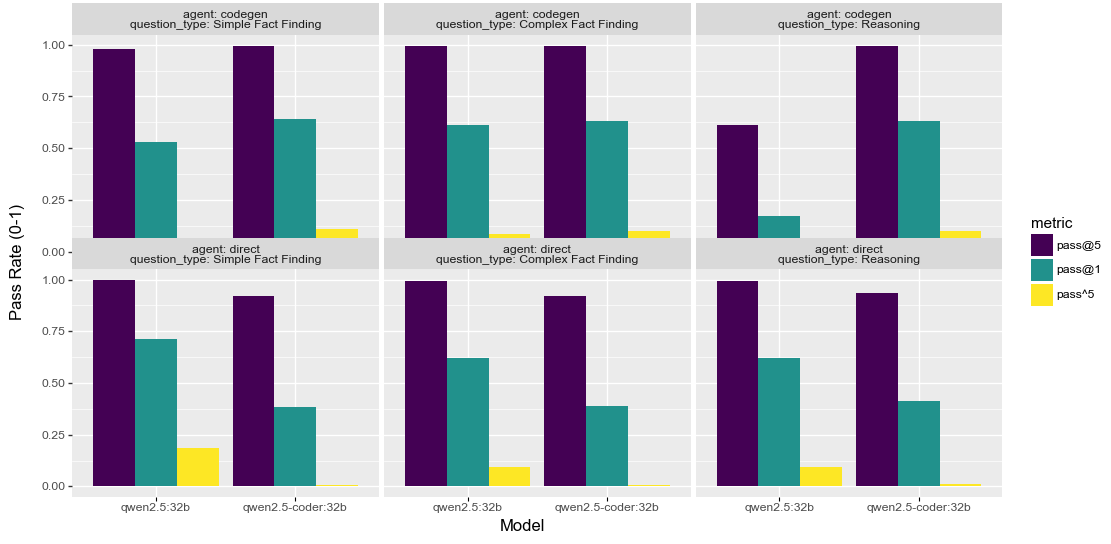

<Figure size 640x480 with 0 Axes>

In [43]:
_pass_metrics = [
    "pass@5",
    "pass@1",
    "pass^5",
]
_pass = pivoted[pivoted['metric'].isin(_pass_metrics)].copy()
_pass["metric"] = pd.Categorical(_pass["metric"], categories=_pass_metrics, ordered=True)

_g1 = (
    ggplot(_pass, aes(x="model", y="value", fill="metric"))
    + geom_bar(stat="identity", position="dodge")
    + facet_wrap(["agent", "question_type"], labeller="label_both")
    + labs(
        x="Model",
        y="Pass Rate (0-1)",
        fill="metric",
        # title="Pass Rate",
    )
)
_figsize = (12, 6)
_g = pw.load_ggplot(_g1, figsize=_figsize)
_g.savefig(f"{OUTPUT_PATH}/finetuning_performance.png", bbox_inches="tight")

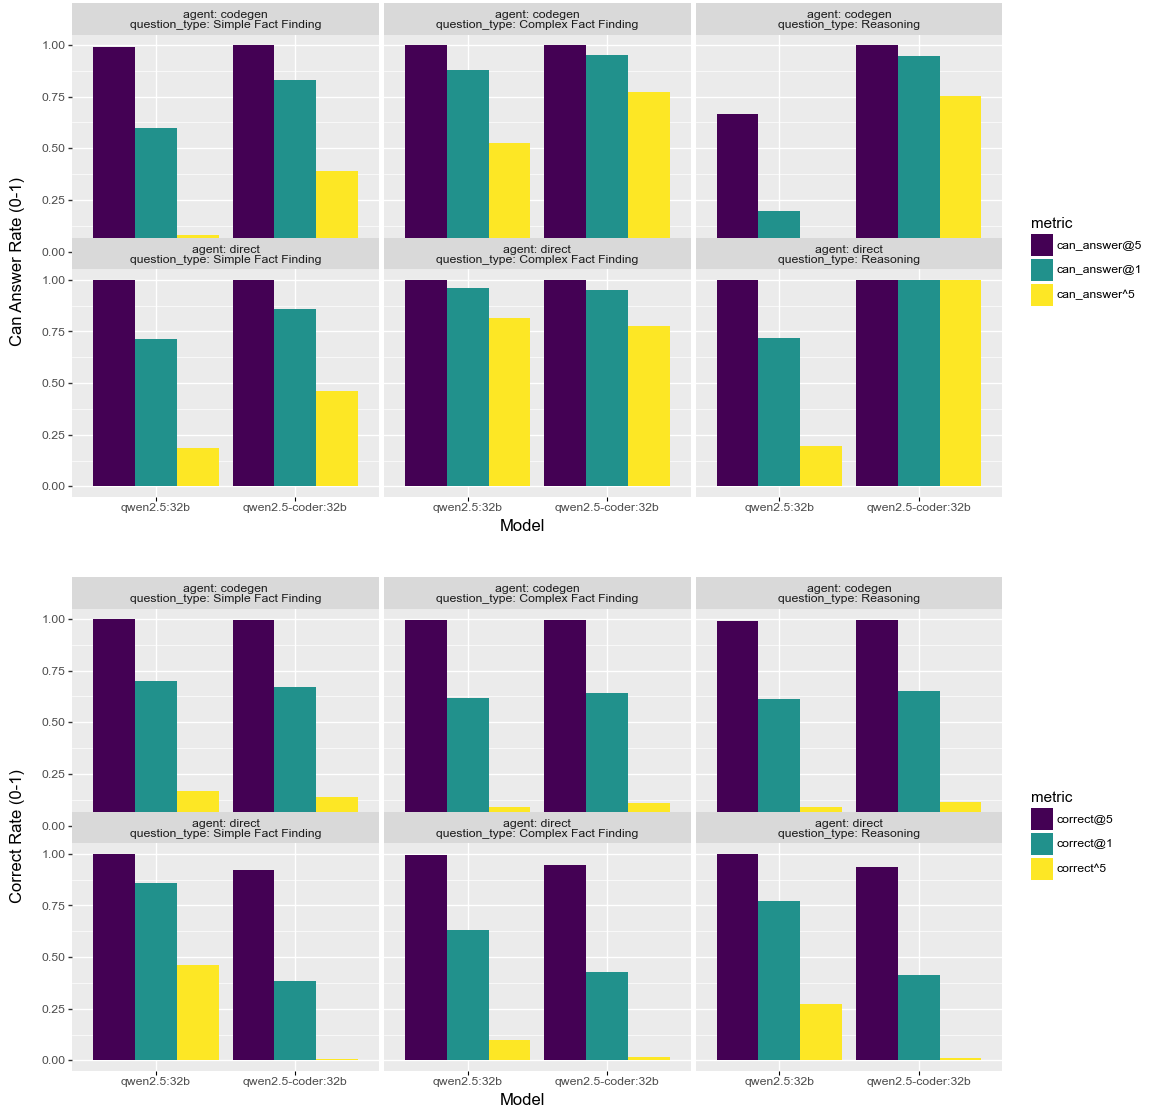

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [44]:
_can_answer_metrics = [
    "can_answer@5",
    "can_answer@1",
    "can_answer^5",
]
_can_answer = pivoted[pivoted['metric'].isin(_can_answer_metrics)].copy()
_can_answer['metric'] = pd.Categorical(_can_answer['metric'], categories=_can_answer_metrics, ordered=True)
_correct_metrics = [
    "correct@5",
    "correct@1",
    "correct^5",
]
_correct = pivoted[pivoted['metric'].isin(_correct_metrics)].copy()
_correct['metric'] = pd.Categorical(_correct['metric'], categories=_correct_metrics, ordered=True)

_g1 = (
    ggplot(_can_answer, aes(x="model", y="value", fill="metric"))
    + geom_bar(stat="identity", position="dodge")
    + facet_wrap(["agent", "question_type"], labeller="label_both")
    + labs(
        x="Model",
        y="Can Answer Rate (0-1)",
        fill="metric",
        # title="Can Answer Rate",
    )
)
_g2 = (
    ggplot(_correct, aes(x="model", y="value", fill="metric"))
    + geom_bar(stat="identity", position="dodge")
    + facet_wrap(["agent", "question_type"], labeller="label_both")
    + labs(
        x="Model",
        y="Correct Rate (0-1)",
        fill="metric",
        # title="Correct Rate",
    )
)

_figsize = (12, 6)
_g = pw.load_ggplot(_g1, figsize=_figsize) / pw.load_ggplot(_g2, figsize=_figsize)
_g.savefig(f"{OUTPUT_PATH}/finetuning_performance_breakdown.png", bbox_inches="tight")